In [1]:
#This file will be used for rough code/experimentation

In [2]:
#importing libraries as needed
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import glob
import scipy
import tensorflow as tf
from scipy import ndimage
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
#from tensorflow.python.keras.preprocessing import image
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import cv2

In [3]:
#read in csv files
csv_path = "C:\\Users\\siyun\\Downloads\\csv_files\\"
df_image_id = pd.read_csv(csv_path + 'nih-cxr-lt_image_ids.csv')
df_label_train = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_train.csv')
df_label_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_test.csv')
df_balanced_test = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-test.csv')
df_balanced_val = pd.read_csv(csv_path + 'nih-cxr-lt_single-label_balanced-val.csv')
#there are 5 files:
#all image ids
#balanced testing dataset
#balanced validation dataset
#normal testing dataset
#normal training dataset

#fixing naming convention of a columns
df_label_train.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_train.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_train.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_train.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_label_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_label_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_label_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_label_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_test.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_test.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_test.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'No Finding':'No_Finding'}, inplace = True)
df_balanced_val.rename(columns = {'Subcutaneous Emphysema':'Subcutaneous_Emphysema'}, inplace = True)
df_balanced_val.rename(columns = {'Tortuous Aorta':'Tortuous_Aorta'}, inplace = True)
df_balanced_val.rename(columns = {'Calcification of the Aorta':'Calcification_of_the_Aorta'}, inplace = True)

#create new dataframes that contain solely heart issues
#include columns only with heart related labels
#remove rows where all values are zero (no finding == 0 -> condition)
#cant do one liner for dropping so have to use conditional drop
df_label_train_heart = df_label_train[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_train_heart = df_label_train_heart.drop(df_label_train_heart[(df_label_train_heart.Cardiomegaly == 0) & (df_label_train_heart.Infiltration == 0) & (df_label_train_heart.Mass == 0) & (df_label_train_heart.Nodule == 0) & (df_label_train_heart.Tortuous_Aorta == 0) & (df_label_train_heart.Calcification_of_the_Aorta == 0) & (df_label_train_heart.No_Finding == 0) ].index)
df_label_test_heart = df_label_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_label_test_heart = df_label_test_heart.drop(df_label_test_heart[(df_label_test_heart.Cardiomegaly == 0) & (df_label_test_heart.Infiltration == 0) & (df_label_test_heart.Mass == 0) & (df_label_test_heart.Nodule == 0) & (df_label_test_heart.Tortuous_Aorta == 0) & (df_label_test_heart.Calcification_of_the_Aorta == 0) & (df_label_test_heart.No_Finding == 0) ].index)
df_balanced_test_heart = df_balanced_test[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_test_heart = df_balanced_test_heart.drop(df_balanced_test_heart[(df_balanced_test_heart.Cardiomegaly == 0) & (df_balanced_test_heart.Infiltration == 0) & (df_balanced_test_heart.Mass == 0) & (df_balanced_test_heart.Nodule == 0) & (df_balanced_test_heart.Tortuous_Aorta == 0) & (df_balanced_test_heart.Calcification_of_the_Aorta == 0) & (df_balanced_test_heart.No_Finding == 0) ].index)
df_balanced_val_heart = df_balanced_val[["id", "Cardiomegaly", "Infiltration", "Mass", "Nodule", "Tortuous_Aorta", "Calcification_of_the_Aorta", "No_Finding", "subject_id"]]
df_balanced_val_heart = df_balanced_val_heart.drop(df_balanced_val_heart[(df_balanced_val_heart.Cardiomegaly == 0) & (df_balanced_val_heart.Infiltration == 0) & (df_balanced_val_heart.Mass == 0) & (df_balanced_val_heart.Nodule == 0) & (df_balanced_val_heart.Tortuous_Aorta == 0) & (df_balanced_val_heart.Calcification_of_the_Aorta == 0) & (df_balanced_val_heart.No_Finding == 0) ].index)
display(df_label_train_heart)

# #create new dataframes that contain solely lung issues (what we are currently concerned with)
# #include columns only with lung related labels
# #remove rows where all values are zero
df_label_train_lung = df_label_train[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[(df_label_train_lung.Atelectasis == 0) & (df_label_train_lung.Consolidation == 0) & (df_label_train_lung.Edema == 0) & (df_label_train_lung.Effusion == 0) & (df_label_train_lung.Emphysema == 0) & (df_label_train_lung.Fibrosis == 0) & (df_label_train_lung.Hernia == 0) & (df_label_train_lung.Infiltration == 0) & (df_label_train_lung.Mass == 0) & (df_label_train_lung.Nodule == 0) & (df_label_train_lung.Pleural_Thickening == 0) & (df_label_train_lung.Pneumonia == 0) & (df_label_train_lung.Pneumothorax == 0)& (df_label_train_lung.Pneumomediastinum == 0) & (df_label_train_lung.No_Finding == 0)].index)
df_label_test_lung = df_label_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[(df_label_test_lung.Atelectasis == 0) & (df_label_test_lung.Consolidation == 0) & (df_label_test_lung.Edema == 0) & (df_label_test_lung.Effusion == 0) & (df_label_test_lung.Emphysema == 0) & (df_label_test_lung.Fibrosis == 0) & (df_label_test_lung.Hernia == 0) & (df_label_test_lung.Infiltration == 0) & (df_label_test_lung.Mass == 0) & (df_label_test_lung.Nodule == 0) & (df_label_test_lung.Pleural_Thickening == 0) & (df_label_test_lung.Pneumonia == 0) & (df_label_test_lung.Pneumothorax == 0)& (df_label_test_lung.Pneumomediastinum == 0) & (df_label_test_lung.No_Finding == 0)].index)
df_balanced_test_lung = df_balanced_test[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[(df_balanced_test_lung.Atelectasis == 0) & (df_balanced_test_lung.Consolidation == 0) & (df_balanced_test_lung.Edema == 0) & (df_balanced_test_lung.Effusion == 0) & (df_balanced_test_lung.Emphysema == 0) & (df_balanced_test_lung.Fibrosis == 0) & (df_balanced_test_lung.Hernia == 0) & (df_balanced_test_lung.Infiltration == 0) & (df_balanced_test_lung.Mass == 0) & (df_balanced_test_lung.Nodule == 0) & (df_balanced_test_lung.Pleural_Thickening == 0) & (df_balanced_test_lung.Pneumonia == 0) & (df_balanced_test_lung.Pneumothorax == 0) & (df_balanced_test_lung.Pneumomediastinum == 0) & (df_balanced_test_lung.No_Finding == 0)].index)
df_balanced_val_lung = df_balanced_val[["id", "Atelectasis", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "Pneumomediastinum", "No_Finding", "subject_id"]]
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[(df_balanced_val_lung.Atelectasis == 0) & (df_balanced_val_lung.Consolidation == 0) & (df_balanced_val_lung.Edema == 0) & (df_balanced_val_lung.Effusion == 0) & (df_balanced_val_lung.Emphysema == 0) & (df_balanced_val_lung.Fibrosis == 0) & (df_balanced_val_lung.Hernia == 0) & (df_balanced_val_lung.Infiltration == 0) & (df_balanced_val_lung.Mass == 0) & (df_balanced_val_lung.Nodule == 0) & (df_balanced_val_lung.Pleural_Thickening == 0) & (df_balanced_val_lung.Pneumonia == 0) & (df_balanced_val_lung.Pneumothorax == 0) & (df_balanced_val_lung.Pneumomediastinum == 0) & (df_balanced_val_lung.No_Finding == 0)].index)
display(df_label_train_lung)

#saving new dataframes
df_label_train_heart.to_csv(csv_path + 'label_train_heart.csv', index=False)
df_label_test_heart.to_csv(csv_path + 'label_test_heart.csv', index=False)
df_balanced_test_heart.to_csv(csv_path + 'balanced_test_heart.csv', index=False)
df_balanced_val_heart.to_csv(csv_path + 'balanced_val_heart.csv', index=False)
df_label_train_lung.to_csv(csv_path + 'label_train_lung.csv', index=False)
df_label_test_lung.to_csv(csv_path + 'label_test_lung.csv', index=False)
df_balanced_test_lung.to_csv(csv_path + 'balanced_test_lung.csv', index=False)
df_balanced_val_lung.to_csv(csv_path + 'balanced_val_lung.csv', index=False)

,id,Cardiomegaly,Infiltration,Mass,Nodule,Tortuous_Aorta,Calcification_of_the_Aorta,No_Finding,subject_id
0,00000001_000.png,1,0,0,0,0,0,0,1
1,00000002_000.png,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,1,30804


,id,Atelectasis,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumomediastinum,No_Finding,subject_id
1,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
5,00000005_003.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30804


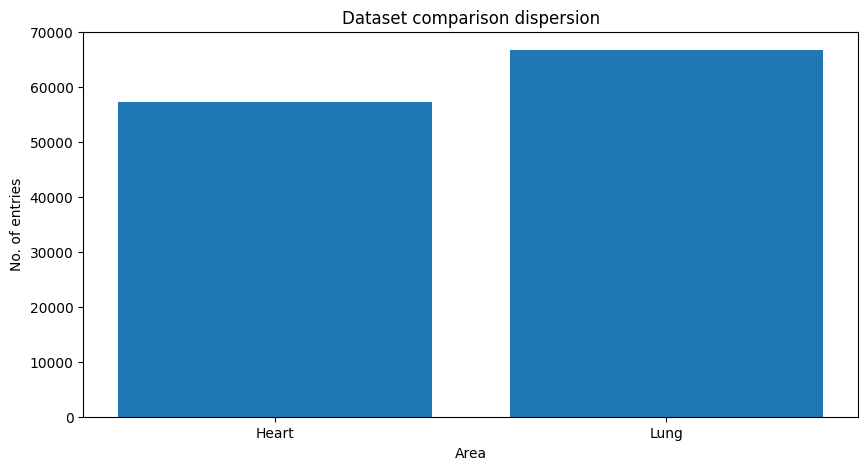

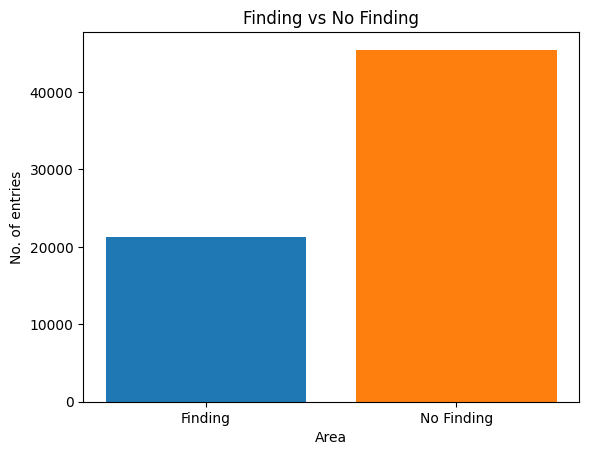

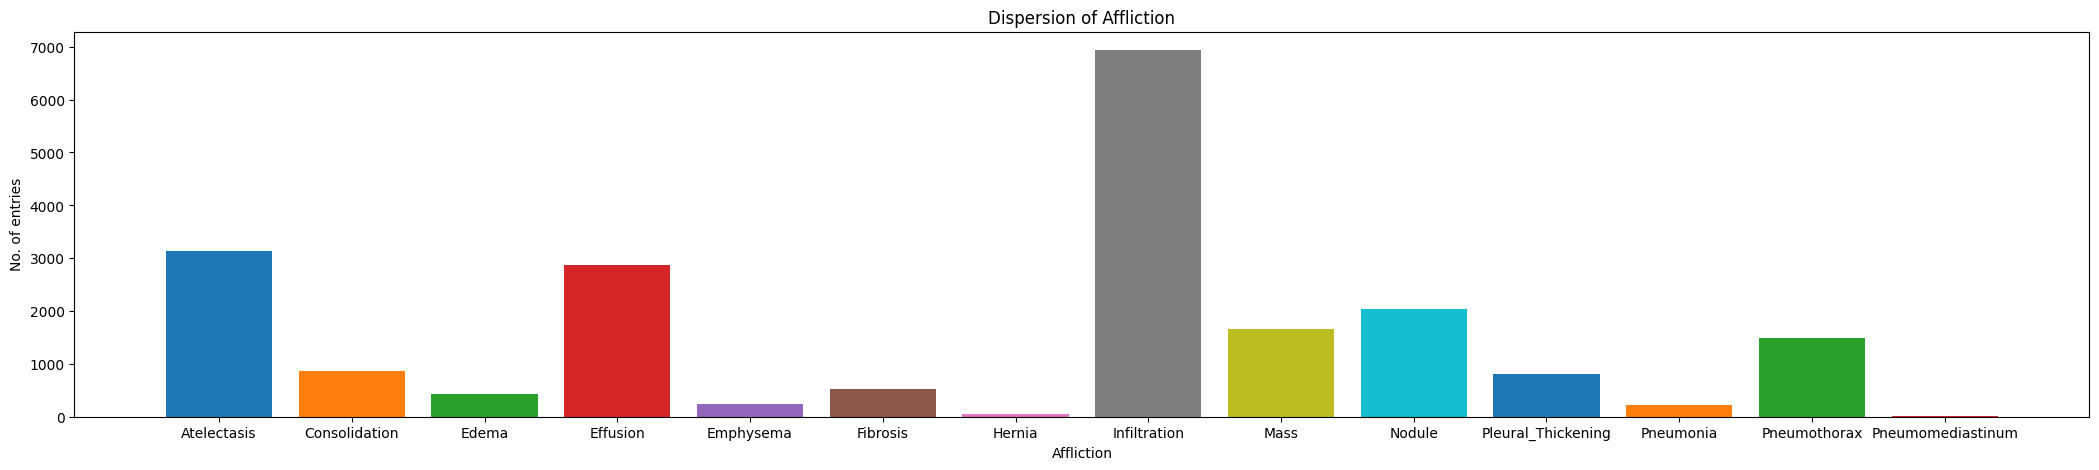

Instances of Pneumomediastinum: 7


In [4]:
#bar graph to show dispersion of dataset
data = {'Heart':len(df_label_train_heart.index), 'Lung':len(df_label_train_lung.index)}
area = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))

#creating the bar plot
plt.bar(area, values)
 
plt.xlabel("Area")
plt.ylabel("No. of entries")
plt.title("Dataset comparison dispersion")
plt.show()
#compare amount of lung diseases in each dataset (train, test, bal_test, bal_val)

#comparing instances if there is a finding or not
num_rows_finding = len(df_label_train_lung[df_label_train_lung['No_Finding'] == 0].index)
num_rows_no_finding = len(df_label_train_lung[df_label_train_lung['No_Finding'] == 1].index)
  
plt.bar('Finding' ,num_rows_finding, label= 'Finding')
plt.bar('No Finding' ,num_rows_no_finding, label = 'No_Finding')
plt.xlabel("Area")
plt.ylabel("No. of entries")
plt.title("Finding vs No Finding")
plt.show()

#dispersion of the various afflictions
num_rows_atelectasis = len(df_label_train_lung[df_label_train_lung['Atelectasis'] == 1].index)
num_rows_consolidation = len(df_label_train_lung[df_label_train_lung['Consolidation'] == 1].index)
num_rows_edema = len(df_label_train_lung[df_label_train_lung['Edema'] == 1].index)
num_rows_effusion = len(df_label_train_lung[df_label_train_lung['Effusion'] == 1].index)
num_rows_emphysema = len(df_label_train_lung[df_label_train_lung['Emphysema'] == 1].index)
num_rows_fibrosis = len(df_label_train_lung[df_label_train_lung['Fibrosis'] == 1].index)
num_rows_hernia = len(df_label_train_lung[df_label_train_lung['Hernia'] == 1].index)
num_rows_infiltration = len(df_label_train_lung[df_label_train_lung['Infiltration'] == 1].index)
num_rows_mass = len(df_label_train_lung[df_label_train_lung['Mass'] == 1].index)
num_rows_nodule = len(df_label_train_lung[df_label_train_lung['Nodule'] == 1].index)
num_rows_pleural_thickening = len(df_label_train_lung[df_label_train_lung['Pleural_Thickening'] == 1].index)
num_rows_pneumonia = len(df_label_train_lung[df_label_train_lung['Pneumonia'] == 1].index)
num_rows_pneumothorax = len(df_label_train_lung[df_label_train_lung['Pneumothorax'] == 1].index)
num_rows_pneumomediastinum = len(df_label_train_lung[df_label_train_lung['Pneumomediastinum'] == 1].index)


  
fig = plt.figure(figsize = (26, 5))
plt.bar('Atelectasis' ,num_rows_atelectasis, label= 'Atelectasis')
plt.bar('Consolidation' ,num_rows_consolidation, label= 'Consolidation')
plt.bar('Edema' ,num_rows_edema, label= 'Edema')
plt.bar('Effusion' ,num_rows_effusion, label= 'Effusion')
plt.bar('Emphysema' ,num_rows_emphysema, label= 'Emphysema')
plt.bar('Fibrosis' ,num_rows_fibrosis, label= 'Fibrosis')
plt.bar('Hernia' ,num_rows_hernia, label= 'Hernia')
plt.bar('Infiltration' ,num_rows_infiltration, label= 'Infiltration')
plt.bar('Mass' ,num_rows_mass, label= 'Mass')
plt.bar('Nodule' ,num_rows_nodule, label= 'Nodule')
plt.bar('Pleural_Thickening' ,num_rows_pleural_thickening, label= 'Pleural_Thickening')
plt.bar('Pneumonia' ,num_rows_pneumonia, label= 'Pneumonia')
plt.bar('Pneumothorax' ,num_rows_pneumothorax, label= 'Pneumothorax')
plt.bar('Pneumomediastinum' ,num_rows_pneumomediastinum, label= 'Pneumomediastinum')

plt.xlabel("Affliction")
plt.ylabel("No. of entries")
plt.title("Dispersion of Affliction")
plt.show()
print("Instances of Pneumomediastinum:", num_rows_pneumomediastinum)

In [5]:
#dropping rows with not many entries
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Edema == 1].index) 
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Emphysema == 1].index) 
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Fibrosis == 1].index) 
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Hernia == 1].index) 
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Pneumonia == 1].index) 
df_label_train_lung = df_label_train_lung.drop(df_label_train_lung[df_label_train_lung.Pneumomediastinum == 1].index) 

df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Edema == 1].index) 
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Emphysema == 1].index) 
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Fibrosis == 1].index) 
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Hernia == 1].index) 
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Pneumonia == 1].index) 
df_label_test_lung = df_label_test_lung.drop(df_label_test_lung[df_label_test_lung.Pneumomediastinum == 1].index) 

df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Edema == 1].index) 
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Emphysema == 1].index) 
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Fibrosis == 1].index) 
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Hernia == 1].index) 
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Pneumonia == 1].index) 
df_balanced_test_lung = df_balanced_test_lung.drop(df_balanced_test_lung[df_balanced_test_lung.Pneumomediastinum == 1].index) 

df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Edema == 1].index) 
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Emphysema == 1].index) 
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Fibrosis == 1].index) 
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Hernia == 1].index) 
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Pneumonia == 1].index) 
df_balanced_val_lung = df_balanced_val_lung.drop(df_balanced_val_lung[df_balanced_val_lung.Pneumomediastinum == 1].index) 

display(df_label_train_lung)

,id,Atelectasis,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumomediastinum,No_Finding,subject_id
1,00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,00000005_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
3,00000005_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
4,00000005_002.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
5,00000005_003.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68053,00030801_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30801
68054,00030802_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30802
68055,00030803_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30803
68056,00030804_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30804


In [6]:
#add pathing to front of images in csv (chest_xrays/)
df_label_train_lung['id'] = "C:\\Users\\siyun\\Downloads\\chest_xrays\\chest_xrays\\" + df_label_train_lung['id'].astype(str)
display(df_label_train_lung)
#add pathing to front of images in csv (chest_xrays/)
df_balanced_val_lung['id'] = "C:\\Users\\siyun\\Downloads\\chest_xrays\\chest_xrays\\" + df_balanced_val_lung['id'].astype(str)
df_balanced_test_lung['id'] = "C:\\Users\\siyun\\Downloads\\chest_xrays\\chest_xrays\\" + df_balanced_test_lung['id'].astype(str)

,id,Atelectasis,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumomediastinum,No_Finding,subject_id
1,C:\Users\siyun\Downloads\chest_xrays\chest_xra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
2,C:\Users\siyun\Downloads\chest_xrays\chest_xra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
3,C:\Users\siyun\Downloads\chest_xrays\chest_xra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
4,C:\Users\siyun\Downloads\chest_xrays\chest_xra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
5,C:\Users\siyun\Downloads\chest_xrays\chest_xra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68053,C:\Users\siyun\Downloads\chest_xrays\chest_xra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30801
68054,C:\Users\siyun\Downloads\chest_xrays\chest_xra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30802
68055,C:\Users\siyun\Downloads\chest_xrays\chest_xra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30803
68056,C:\Users\siyun\Downloads\chest_xrays\chest_xra...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,30804


In [7]:
# from sklearn.preprocessing import LabelEncoder
#may have to one hot encode No_Finding (not completely sure)
# encode = LabelEncoder()

In [8]:
# For_Prediction_Class = encode.fit_transform(df_label_train_lung["No_Finding"])

In [9]:
#preprocessing and splitting of train and test data
Train_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [10]:
#preprocessing of training images
Train_IMG_Set = Train_Generator.flow_from_dataframe(dataframe=df_label_train_lung,
                                                   x_col="id",
                                                   y_col="No_Finding", #can add more categories here
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=4,
                                                   subset="training")

Found 58730 validated image filenames.


In [11]:
Validation_Generator = ImageDataGenerator(rescale=1./255,
                                    shear_range=0.3,
                                    zoom_range=0.2,
                                    brightness_range=[0.2,0.9],
                                    rotation_range=30,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode="nearest",
                                    validation_split=0.1)

In [12]:
#preprocessing of validation images
Validation_IMG_Set = Validation_Generator.flow_from_dataframe(dataframe=df_balanced_val_lung,
                                                   x_col="id",
                                                   y_col="No_Finding",
                                                   color_mode="rgb",
                                                   class_mode="raw",
                                                   batch_size=4,
                                                   subset="validation")

Found 13 validated image filenames.


In [13]:
Test_Generator = ImageDataGenerator(rescale=1./255)

In [14]:
#preprocessing of testing images
Test_IMG_Set = Test_Generator.flow_from_dataframe(dataframe=df_balanced_test_lung,
                                                 x_col="id",
                                                 y_col="No_Finding",
                                                 color_mode="rgb",
                                                 class_mode="raw",
                                                 batch_size=4)

Found 270 validated image filenames.


In [15]:
#additional image preprocessing 
#possibilities : remove some no finding, limit afflictions we are testing for, add cluster column, alter resolution

In [16]:
#validating shapes
for data_batch,label_batch in Train_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break#validating shapes for the model

DATA SHAPE:  (4, 256, 256, 3)
LABEL SHAPE:  (4,)


In [17]:
for data_batch,label_batch in Validation_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (4, 256, 256, 3)
LABEL SHAPE:  (4,)


In [18]:
for data_batch,label_batch in Test_IMG_Set:
    print("DATA SHAPE: ",data_batch.shape)
    print("LABEL SHAPE: ",label_batch.shape)
    break

DATA SHAPE:  (4, 256, 256, 3)
LABEL SHAPE:  (4,)


In [19]:
#implementing various machine learning models:
#RESNET - David
#LENET - Siyung
#ALEXNET - John
#BASICCNN - Jagrit

In [20]:
model = tf.keras.Sequential([
    #1st conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    #2nd conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    #3rd conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    #4th conv. layer
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1,  activation=tf.nn.softmax)
])

In [21]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
history= model.fit(Train_IMG_Set, epochs = 5, verbose = 1, validation_data =Validation_IMG_Set)

Epoch 1/5
  615/14683 [>.............................] - ETA: 34:24 - loss: 0.0000e+00 - accuracy: 0.7020

In [ ]:
test_loss, test_acc=model.evaluate(Validation_IMG_Set)
print('Test accuracy:', test_acc)